In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.optimizers import Adam  #설정해줘야함
from keras.models import load_model

In [3]:
cd /content/drive/Othercomputers/내 노트북/07_PJT_final_01/01_clothes_classification

/content/drive/Othercomputers/내 노트북/07_PJT_final_01/01_clothes_classification


In [4]:
img_size = 128
channel=3

In [5]:
train_datagen = ImageDataGenerator( 
        rescale=1./255,         # 픽셀 값을 0~1 범위로 변환
        rotation_range=40,      # 40도까지 회전
        width_shift_range=0.2,  # 20%까지 좌우 이동
        height_shift_range=0.2, # 20%까지 상하 이동
        shear_range=0.2,        # 20%까지 기울임
        zoom_range=0.2,         # 20%까지 확대
        horizontal_flip=True,   # 좌우 뒤집기
    )
train_generator = train_datagen.flow_from_directory(
    './dataset/Train',
    batch_size=100,      
    class_mode='categorical', 
    target_size=(img_size, img_size)) 
valid_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
valid_generator = valid_datagen.flow_from_directory(
    './dataset/Validation',
    batch_size=40,      
    class_mode='categorical', 
    target_size=(img_size, img_size))
test_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
test_generator = test_datagen.flow_from_directory(
    './dataset/test',
    batch_size=10,      
    class_mode='categorical', 
    target_size=(img_size, img_size),
    shuffle=False)

Found 32426 images belonging to 4 classes.
Found 7854 images belonging to 4 classes.
Found 278 images belonging to 4 classes.


#  ResNet50 
- imagenet 전이학습
- 은닉층
    * Flatten()
- 출력층
    * Dense(4, activation='softmax')

In [6]:
resnet50 = tf.keras.applications.ResNet50(weights='imagenet',
                                          include_top=False,
                                          input_shape=(img_size, img_size, 3))
resnet50.trainable = False

In [7]:
model = Sequential()
model.add(resnet50)
model.add(Flatten())
model.add(Dense(4, activation='softmax')) # 다중분류 4개로 변경
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 4)                 131076    
                                                                 
Total params: 23,718,788
Trainable params: 131,076
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
# 모델 환경설정
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [9]:
model_name = './model/resnet50_03_{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=model_name, monitor='val_loss',save_best_only=True) # 성능이 개선될떄만 저장하도록
earlystopping = EarlyStopping(monitor='val_loss', patience=5) # 5번동안 성능개선이 없으면 학습 조기종료

In [10]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=valid_generator,
                    callbacks = [[earlystopping, checkpointer]]) 

Epoch 1/100
325/325 [==============================] - 20821s 64s/step - loss: 0.9742 - accuracy: 0.6453 - val_loss: 0.8132 - val_accuracy: 0.6891
Epoch 2/100
325/325 [==============================] - 796s 2s/step - loss: 0.8980 - accuracy: 0.6725 - val_loss: 0.8144 - val_accuracy: 0.6870
Epoch 3/100
325/325 [==============================] - 797s 2s/step - loss: 0.8735 - accuracy: 0.6791 - val_loss: 0.8386 - val_accuracy: 0.6868
Epoch 4/100
325/325 [==============================] - 796s 2s/step - loss: 0.8680 - accuracy: 0.6826 - val_loss: 0.7207 - val_accuracy: 0.7310
Epoch 5/100
325/325 [==============================] - 797s 2s/step - loss: 0.8512 - accuracy: 0.6881 - val_loss: 0.7648 - val_accuracy: 0.7103
Epoch 6/100
325/325 [==============================] - 798s 2s/step - loss: 0.8459 - accuracy: 0.6896 - val_loss: 0.7725 - val_accuracy: 0.7122
Epoch 7/100
325/325 [==============================] - 799s 2s/step - loss: 0.8355 - accuracy: 0.6934 - val_loss: 0.6957 - val_accura

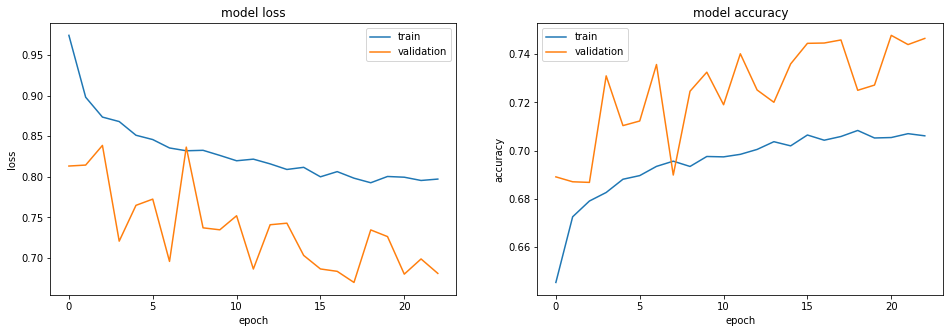

In [11]:
# 모델 학습 과정 시각화
plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

In [12]:
model.save('./model/ResNet_3.h5')

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt 
plt.rc('font', family='Malgun Gothic')

In [14]:
Y_pred = model.predict(test_generator)
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=1) 

result_dict = dict(map(reversed, test_generator.class_indices.items()))
class_names = list(result_dict.values())

print('-- Confusion Matrix --')
print(confusion_matrix(classes, y_pred))

print('-- Classification Report --')
print(classification_report(classes, y_pred, target_names=class_names))


-- Confusion Matrix --
[[21  0  2 47]
 [ 7 14  5 43]
 [ 0  1  3 65]
 [ 6  0  2 62]]
-- Classification Report --
              precision    recall  f1-score   support

     bottoms       0.62      0.30      0.40        70
   one-piece       0.93      0.20      0.33        69
   outerwear       0.25      0.04      0.07        69
        tops       0.29      0.89      0.43        70

    accuracy                           0.36       278
   macro avg       0.52      0.36      0.31       278
weighted avg       0.52      0.36      0.31       278



findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


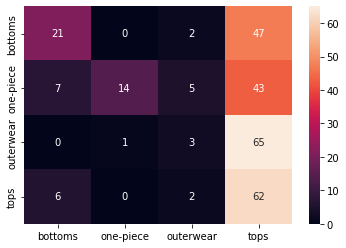

In [15]:
sns.heatmap(confusion_matrix(classes, y_pred), annot=True, fmt='d',
            xticklabels=['bottoms', 'one-piece', 'outerwear', 'tops'] ,
            yticklabels=['bottoms', 'one-piece', 'outerwear', 'tops'] )

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


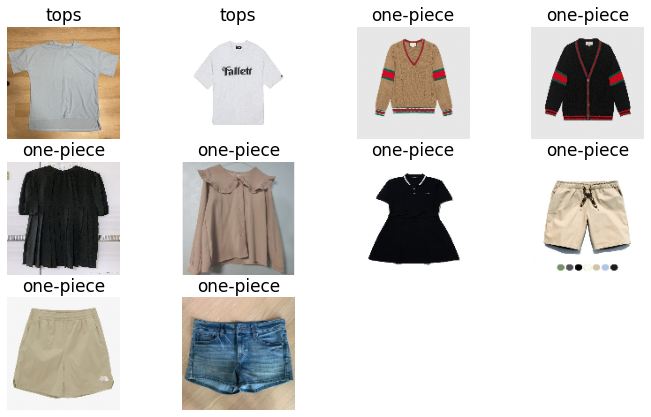

In [17]:
# 구글에서 가져온 실제 이미지로 예측 결과 확인

class_dict = {0:'bottoms', 1:'one-piece', 2:'outerwear', 3:'tops'}

fig = plt.figure(figsize=(12,12))
i=0
for img in glob.glob('./dataset/test1/*.jpg'):
    ax = plt.subplot(4,4,i+1) 
    test_img = cv2.imread(img)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(img_size,img_size))/255.0
    test_img_input = test_img.reshape((1,)+test_img.shape)
    pred = model.predict(test_img_input)
    pred_class = class_dict[np.argmax(pred, axis=1)[0]]
    ax.imshow(test_img)
    ax.axis('off')
    ax.set_title(f'{pred_class}',fontsize=17)
    i += 1
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.7, wspace=0.2, hspace=0.2)
plt.show()

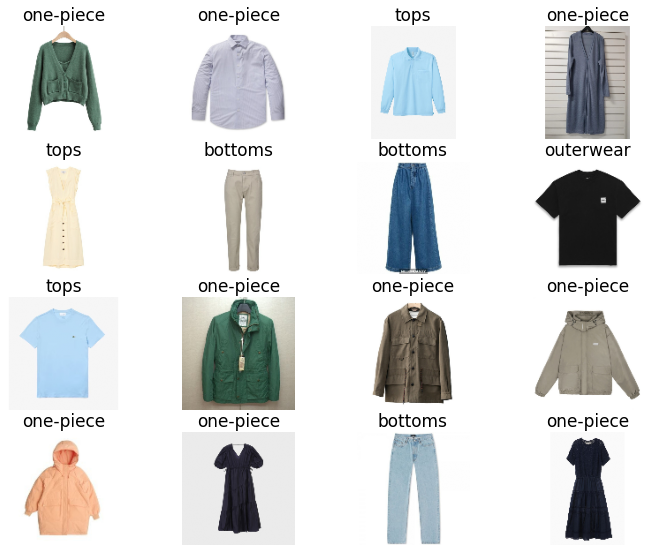

In [18]:
# 구글에서 가져온 실제 이미지로 예측 결과 확인

class_dict = {0:'bottoms', 1:'one-piece', 2:'outerwear', 3:'tops'}

fig = plt.figure(figsize=(12,12))
i=0
for img in glob.glob('./dataset/test2/*.jpg'):
    ax = plt.subplot(4,4,i+1) 
    test_img = cv2.imread(img)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(img_size,img_size))/255.0
    test_img_input = test_img.reshape((1,)+test_img.shape)
    pred = model.predict(test_img_input)
    pred_class = class_dict[np.argmax(pred, axis=1)[0]]
    ax.imshow(test_img)
    ax.axis('off')
    ax.set_title(f'{pred_class}',fontsize=17)
    i += 1
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.7, wspace=0.2, hspace=0.2)
plt.show()

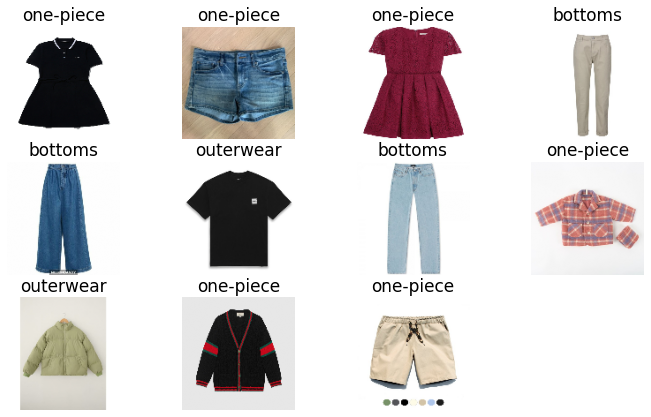

In [19]:
# 구글에서 가져온 실제 이미지로 예측 결과 확인

class_dict = {0:'bottoms', 1:'one-piece', 2:'outerwear', 3:'tops'}

fig = plt.figure(figsize=(12,12))
i=0
for img in glob.glob('./dataset/test3/*.jpg'):
    ax = plt.subplot(4,4,i+1) 
    test_img = cv2.imread(img)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(img_size,img_size))/255.0
    test_img_input = test_img.reshape((1,)+test_img.shape)
    pred = model.predict(test_img_input)
    pred_class = class_dict[np.argmax(pred, axis=1)[0]]
    ax.imshow(test_img)
    ax.axis('off')
    ax.set_title(f'{pred_class}',fontsize=17)
    i += 1
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.7, wspace=0.2, hspace=0.2)
plt.show()

# 모델 이어서 학습하기

In [ ]:
# 모델 가져오기
model = load_model('./model/ResNet_1.h5')

In [ ]:
model_name = './model/resnet50_02_{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=model_name, monitor='val_loss',save_best_only=True) # 성능이 개선될떄만 저장하도록
earlystopping = EarlyStopping(monitor='val_loss', patience=5) # 5번동안 성능개선이 없으면 학습 조기종료

In [ ]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=valid_generator,
                    callbacks = [[earlystopping, checkpointer]]) 

Epoch 1/100
325/325 [==============================] - 21426s 66s/step - loss: 0.5474 - accuracy: 0.7910 - val_loss: 0.5123 - val_accuracy: 0.8066
Epoch 2/100
325/325 [==============================] - 728s 2s/step - loss: 0.5456 - accuracy: 0.7912 - val_loss: 0.5107 - val_accuracy: 0.7974
Epoch 3/100
325/325 [==============================] - 730s 2s/step - loss: 0.5448 - accuracy: 0.7918 - val_loss: 0.5357 - val_accuracy: 0.7892
Epoch 4/100
325/325 [==============================] - 729s 2s/step - loss: 0.5410 - accuracy: 0.7923 - val_loss: 0.5349 - val_accuracy: 0.7928
Epoch 5/100
325/325 [==============================] - 729s 2s/step - loss: 0.5419 - accuracy: 0.7923 - val_loss: 0.5130 - val_accuracy: 0.7990
Epoch 6/100
325/325 [==============================] - 730s 2s/step - loss: 0.5407 - accuracy: 0.7938 - val_loss: 0.5271 - val_accuracy: 0.7921
Epoch 7/100
325/325 [==============================] - 732s 2s/step - loss: 0.5389 - accuracy: 0.7935 - val_loss: 0.5332 - val_accura

In [ ]:
# 구글에서 가져온 실제 이미지로 예측 결과 확인

class_dict = {0:'bottoms', 1:'one-piece', 2:'outerwear', 3:'tops'}

fig = plt.figure(figsize=(12,12))
i=0
for img in glob.glob('./dataset/test/*.jpg'):
    ax = plt.subplot(4,4,i+1) 
    test_img = cv2.imread(img)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(64,64))/255.0
    test_img_input = test_img.reshape((1,)+test_img.shape)
    pred = model.predict(test_img_input)
    pred_class = class_dict[np.argmax(pred, axis=1)[0]]
    ax.imshow(test_img)
    ax.axis('off')
    ax.set_title(f'{pred_class}',fontsize=17)
    i += 1
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.7, wspace=0.2, hspace=0.2)
plt.show()